In [520]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [521]:
# Definir as variáveis iniciais
num_nodes = 0
min_neighbors = 0
max_neighbors = 0
resources = {}
edges = []


# Abrir o arquivo de entrada
with open("entrada.txt", "r") as arquivo:
    # Ler cada linha do arquivo
    achou_resources = False
    achou_edges = False
    for linha in arquivo:
        # Remover espaços em branco no início e no final da linha
        linha = linha.strip()
        # Verificar se a linha não está vazia
        if linha:
           if('num_nodes:' in linha):
                num_nodes = int(linha.split(':')[1])
           if('min_neighbors:' in linha):
                min_neighbors = int(linha.split(':')[1])
           if('max_neighbors:' in linha):
                max_neighbors = int(linha.split(':')[1])
           if(achou_resources and 'edges' not in linha):
                chave = linha.split(":")[0]
                valor = linha.split(":")[1].replace(" ","").split(",")
                resources[chave]=valor
           if(achou_edges and 'resources' not in linha):
                values = linha.replace(" ","").split(",")
                edges.append(values)
           if('resources:' in linha):
                achou_resources = True
                achou_edges = False
           if('edges:' in linha):
               achou_resources = False
               achou_edges = True
           



            
  
          

# Imprimir as variáveis lidas do arquivo
print("num_nodes:", num_nodes)
print("min_neighbors:", min_neighbors)
print("max_neighbors:", max_neighbors)
print("resources:", resources)
print("edges:", edges)


num_nodes: 6
min_neighbors: 1
max_neighbors: 3
resources: {'n1': ['r1', 'r2', 'r3'], 'n2': ['r4', 'r5'], 'n3': ['r6', 'r7'], 'n4': ['r8'], 'n5': ['r9'], 'n6': ['r10']}
edges: [['n1', 'n2'], ['n1', 'n3'], ['n2', 'n4'], ['n3', 'n4'], ['n4', 'n5'], ['n4', 'n6'], ['n5', 'n2'], ['n6', 'n3']]


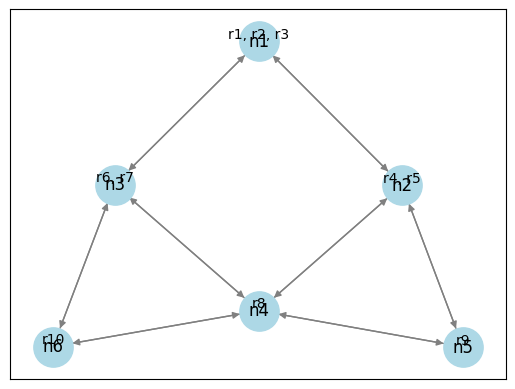

In [522]:

# Criando um novo grafo direcionado
grafo = nx.DiGraph()


def criarGrafo():

    for i in range(1, num_nodes + 1):
        node_name = 'n{}'.format(i)
        grafo.add_node(node_name,recursos=resources[node_name],msgs_recebida=[])

    # Adicionando as arestas ao grafo
    for edge in edges:
        source = edge[0]
        target = edge[1]
        source2 = edge[1]
        target2= edge[0]
    
        grafo.add_edge(source, target)
        grafo.add_edge(source2, target2)

criarGrafo()



pos = nx.spring_layout(grafo, seed=42)
node_labels = {node: f"{', '.join(grafo.nodes[node]['recursos'])}" for node in grafo.nodes()}
nx.draw_networkx(grafo, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, edge_color='gray')
nx.draw_networkx_labels(grafo, pos, labels=node_labels, font_size=10, verticalalignment="bottom")

# Exibindo o gráfico
plt.show()



In [523]:
def mandar_msg(neighbors,recurso,node):
    if(True):
        for neighbor in neighbors:
            msgs = grafo.nodes[neighbor]['msgs_recebida']
            if(msgs):
                print(msgs[-1])
            msgs.append({node:recurso}) 



def flood_fill( start_node,recurso):
    visited = []  # Conjunto para armazenar os nós visitados
    stack = [start_node]  # Pilha para armazenar os nós a serem visitados
    
    achou = False
    while stack:
        node = stack.pop()  # Retira o último nó da pilha
        achou = recurso in grafo.nodes[node]['recursos']
        if node not in visited:
            visited.append(node)
            neighbors = list(grafo.neighbors(node))  # Obtém os vizinhos do nó atual
            mandar_msg(neighbors,recurso,node)
            for neighbor in neighbors:
                if neighbor not in visited:
                        stack.insert(0,neighbor)  # Adiciona os vizinhos não visitados na pilha
        if(achou):  break
    return visited


def random_walk(start_node,ttl,recurso):
    current_node = start_node
    walk = [current_node]
    achou = False

    for _ in range(ttl):
        neighbors = list(grafo.neighbors(current_node))
        achou = recurso in grafo.nodes[current_node]['recursos']
        mandar_msg(neighbors,recurso,current_node)
        if len(neighbors) == 0 or achou:
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node

    return walk
    



In [524]:
def busca(node_id,resource_id,ttl,algo):
    criarGrafo()
    if(algo == 'flooding'):
        flood_fill(node_id,resource_id)
    if(algo == 'random_walk'):
        random_walk(node_id,ttl,resource_id)


busca('n1','r10',4,'flooding')

{'n2': 'r10'}
{'n2': 'r10'}
{'n1': 'r10'}
{'n1': 'r10'}
{'n2': 'r10'}
{'n3': 'r10'}
{'n3': 'r10'}
{'n4': 'r10'}
{'n5': 'r10'}
{'n4': 'r10'}


In [525]:
for node in grafo.nodes:
    print(str(node) + ": " + str(grafo.nodes[node]))

n1: {'recursos': ['r1', 'r2', 'r3'], 'msgs_recebida': [{'n2': 'r10'}, {'n3': 'r10'}]}
n2: {'recursos': ['r4', 'r5'], 'msgs_recebida': [{'n1': 'r10'}, {'n4': 'r10'}, {'n5': 'r10'}]}
n3: {'recursos': ['r6', 'r7'], 'msgs_recebida': [{'n1': 'r10'}, {'n4': 'r10'}, {'n6': 'r10'}]}
n4: {'recursos': ['r8'], 'msgs_recebida': [{'n2': 'r10'}, {'n3': 'r10'}, {'n5': 'r10'}, {'n6': 'r10'}]}
n5: {'recursos': ['r9'], 'msgs_recebida': [{'n2': 'r10'}, {'n4': 'r10'}]}
n6: {'recursos': ['r10'], 'msgs_recebida': [{'n3': 'r10'}, {'n4': 'r10'}]}
